In [28]:
# Autoencoder implementation for anomaly detection, code associated with the paper Anomaly Detection Using Machine Learning
import os
import pandas as pd
import numpy as np
import random
from sklearn import preprocessing
import seaborn as sns
sns.set(color_codes=True)
import matplotlib.pyplot as plt
%matplotlib inline
import sys
from numpy.random import seed
import tensorflow
import tensorboard
from keras.layers import Input, Dropout, Flatten
from keras.layers.core import Dense 
from keras.layers.convolutional import Conv2D
from keras.models import Model, Sequential, load_model
from keras import regularizers
from keras.models import model_from_json

In [29]:
#Data ingestion was done this way to allow for multiple files to be loaded and concatenated into a single file
data_dir = 'Dataverse'
merged_data = pd.DataFrame() 

In [30]:
for filename in os.listdir(data_dir):
    print(filename)
    dataset=pd.read_csv(os.path.join(data_dir, filename), sep=',', float_precision='high')
   # dataset_mean_abs = np.array(dataset.abs().mean())
   # dataset_mean_abs = pd.DataFrame(dataset_mean_abs.reshape(1,12))
   # merged_data = merged_data.append(dataset_mean_abs)

#dataset=pd.read_csv('file.csv',sep=',',float_precision='high')
merged_data = dataset

combed.csv


In [31]:
#Setting the time column as the index for the pandas dataframe
merged_data['time'] = pd.to_datetime(merged_data['time'])
merged_data = merged_data.sort_index()

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


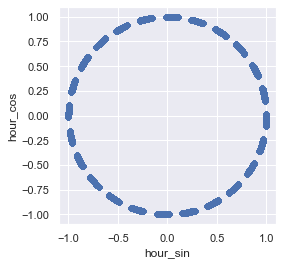

In [32]:
ax = merged_data.plot.scatter('hour_sin', 'hour_cos').set_aspect('equal')

In [33]:
merged_data.set_index('time', inplace=True)

In [34]:
merged_data

energy     power   current  hour_sin  hour_cos  \
time                                                                    
2014-06-02 07:56:23  0.000000  0.694100  0.688114  0.933580 -0.358368   
2014-06-02 07:56:53  0.000019  0.714005  0.706112  0.933580 -0.358368   
2014-06-02 07:57:23  0.000037  0.695739  0.690100  0.933580 -0.358368   
2014-06-02 07:57:53  0.000057  0.695680  0.690884  0.933580 -0.358368   
2014-06-02 07:58:23  0.000075  0.754291  0.739050  0.932008 -0.362438   
...                       ...       ...       ...       ...       ...   
2014-07-01 03:57:53  0.999943  0.531026  0.572269  0.777146  0.629320   
2014-07-01 03:58:23  0.999956  0.532212  0.573410  0.779884  0.625923   
2014-07-01 03:58:53  0.999971  0.583963  0.637704  0.779884  0.625923   
2014-07-01 03:59:23  0.999985  0.563034  0.597563  0.779884  0.625923   
2014-07-01 03:59:53  1.000000  0.591535  0.641552  0.779884  0.625923   

                      day_sin   day_cos  week_sin  week_cos  
time                                                         
2014-06-02 07:56:23  0.207912  0.978148  0.974928 -0.222521  
2014-06-02 07:56:53  0.207912  0.978148  0.974928 -0.222521  
2014-06-02 07:57:23  0.207912  0.978148  0.974928 -0.222521  
2014-06-02 07:57:53  0.207912  0.978148  0.974928 -0.222521  
2014-06-02 07:58:23  0.207912  0.978148  0.974928 -0.222521  
...                       ...       ...       ...       ...  
2014-07-01 03:57:53  0.000000  1.000000  0.781831  0.623490  
2014-07-01 03:58:23  0.000000  1.000000  0.781831  0.623490  
2014-07-01 03:58:53  0.000000  1.000000  0.781831  0.623490  
2014-07-01 03:59:23  0.000000  1.000000  0.781831  0.623490  
2014-07-01 03:59:53  0.000000  1.000000  0.781831  0.623490  

[82888 rows x 9 columns]

<AxesSubplot:xlabel='time'>

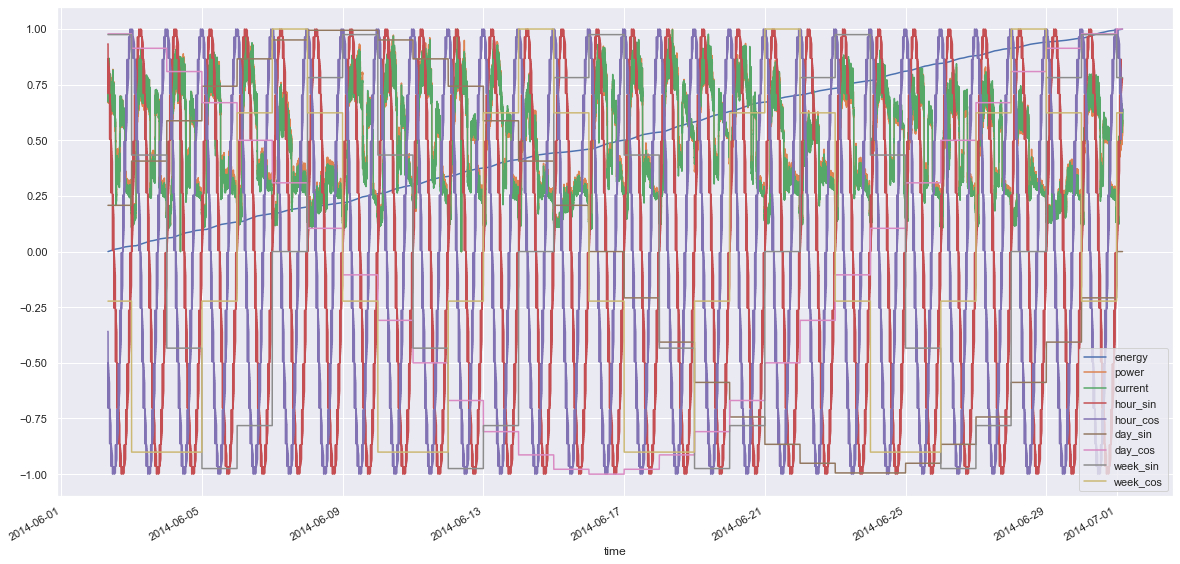

In [12]:
#Exploratyory visulization of the variables 
merged_data.plot(figsize = (20,10))

<AxesSubplot:xlabel='time'>

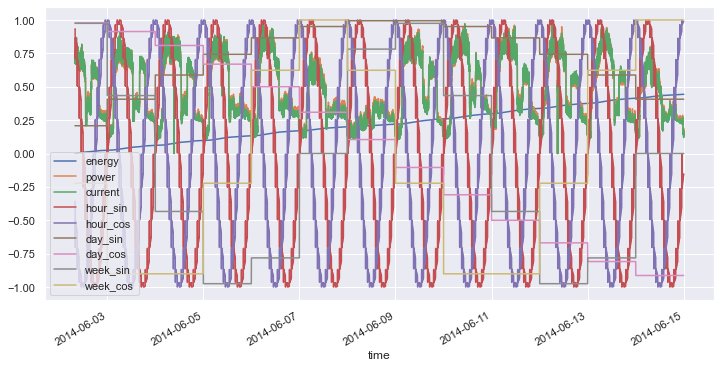

In [35]:
#Splitting the train and test sets
dataset_train = merged_data['2014-06-01 00:00:00':'2014-06-15 00:00:00'] 
dataset_test = merged_data['2014-06-15 00:00:00':'2014-07-01 00:00:00'] 
dataset_train.plot(figsize = (12,6))

<AxesSubplot:xlabel='time'>

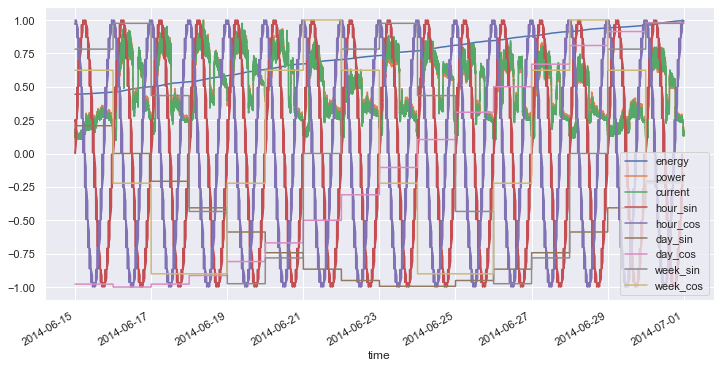

In [36]:
dataset_test.plot(figsize=(12,6))

In [15]:
merged_data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 82888 entries, 2014-06-02 07:56:23 to 2014-07-01 03:59:53
Data columns (total 9 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   energy    82888 non-null  float64
 1   power     82888 non-null  float64
 2   current   82888 non-null  float64
 3   hour_sin  82888 non-null  float64
 4   hour_cos  82888 non-null  float64
 5   day_sin   82888 non-null  float64
 6   day_cos   82888 non-null  float64
 7   week_sin  82888 non-null  float64
 8   week_cos  82888 non-null  float64
dtypes: float64(9)
memory usage: 8.3 MB


In [17]:
#Data normalization
scaler = preprocessing.MinMaxScaler()
X_train = pd.DataFrame(scaler.fit_transform(dataset_train),
                              columns=dataset_train.columns, 
                              index=dataset_train.index)


X_train.sample(frac=1)
X_test = pd.DataFrame(scaler.fit_transform(dataset_test), 
                              columns=dataset_test.columns, 
                              index=dataset_test.index)



In [16]:
X_train = dataset_train
X_test = dataset_test

In [17]:
#Autoencoder model creation using 10 epochs with a batch size of 128. Sigmoid activation is used for the output layer
#whereas relu is used for the other layers. 

seed(10)
tensorflow.random.set_seed(10)
act_func = 'relu'

# Input layer:
model=Sequential()
# First hidden layer, connected to input vector X. 
model.add(Dense(128,activation=act_func,
                kernel_initializer='glorot_uniform',
                kernel_regularizer=regularizers.l2(0.0),
                input_shape=(dataset_train.shape[1],)
               )
         )

model.add(Dense(64,activation=act_func,
                kernel_initializer='glorot_uniform'))

model.add(Dense(128,activation=act_func,
                kernel_initializer='glorot_uniform'))

model.add(Dense(dataset_train.shape[1],activation='sigmoid',
                kernel_initializer='glorot_uniform'))

model.compile(loss='mse',optimizer='adam')

# Train model for 100 epochs, batch size of 10: 
NUM_EPOCHS=10
BATCH_SIZE=128

In [51]:
#Model training and validation
history=model.fit(np.array(X_train),np.array(X_train),
                  batch_size=BATCH_SIZE, 
                  epochs=NUM_EPOCHS,
                  validation_split=0.05,
                  verbose = 1)

Epoch 1/10
385/385 [==============================] - 1s 3ms/step - loss: 0.1967 - val_loss: 0.2442
Epoch 2/10
385/385 [==============================] - 1s 3ms/step - loss: 0.1673 - val_loss: 0.2437
Epoch 3/10
385/385 [==============================] - 1s 3ms/step - loss: 0.1672 - val_loss: 0.2431
Epoch 4/10
385/385 [==============================] - 1s 3ms/step - loss: 0.1671 - val_loss: 0.2423
Epoch 5/10
385/385 [==============================] - 1s 3ms/step - loss: 0.1670 - val_loss: 0.2435
Epoch 6/10
385/385 [==============================] - 1s 3ms/step - loss: 0.1670 - val_loss: 0.2434
Epoch 7/10
385/385 [==============================] - 1s 3ms/step - loss: 0.1669 - val_loss: 0.2424
Epoch 8/10
385/385 [==============================] - 1s 3ms/step - loss: 0.1669 - val_loss: 0.2444
Epoch 9/10
385/385 [==============================] - 1s 3ms/step - loss: 0.1669 - val_loss: 0.2451
Epoch 10/10
385/385 [==============================] - 1s 3ms/step - loss: 0.1669 - val_loss: 0.2430

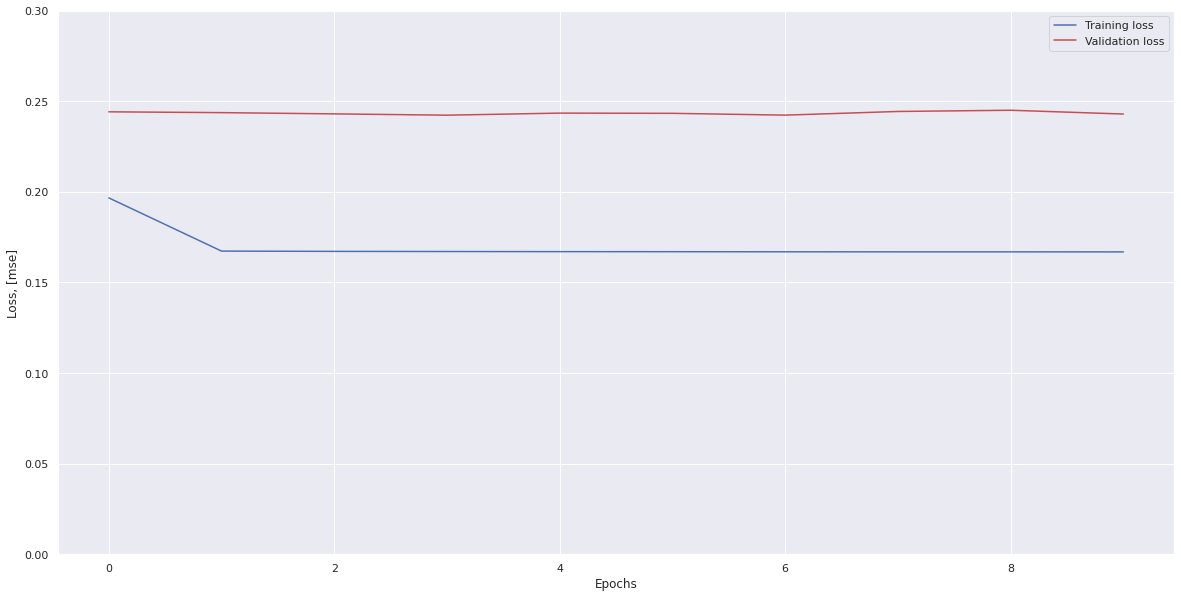

In [54]:
#Plot of the training loss
plt.figure(figsize=(20,10)) 
plt.plot(history.history['loss'],
         'b',
         label='Training loss')
plt.plot(history.history['val_loss'],
         'r',
         label='Validation loss')
plt.legend(loc='upper right')
plt.xlabel('Epochs')
plt.ylabel('Loss, [mse]')
plt.ylim([0.0,.3])
plt.show()

(0.0, 1.0)

<Figure size 1440x720 with 0 Axes>

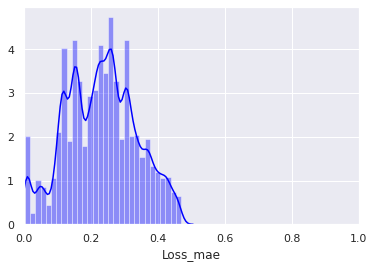

In [55]:
#To determine the threshold for anomalies, the mean distribution of the loss/reconstruction error is used.
#The mean distribution of the reconstruction error is plotted for visualization

plt.figure(figsize=(20,10)) 
X_pred = model.predict(np.array(X_train))
X_pred = pd.DataFrame(X_pred, 
                      columns=X_train.columns)
X_pred.index = X_train.index

scored = pd.DataFrame(index=X_train.index)
scored['Loss_mae'] = np.mean(np.abs(X_pred-X_train), axis = 1)
plt.figure()
sns.distplot(scored['Loss_mae'],
             bins = 30, 
             kde= True,
            color = 'blue');
plt.xlim([0.0,1])

In [64]:
#The threshold for errors is set to three standard deviations above the mean, however the threshold will vary between datasets.

X_pred = model.predict(np.array(X_test))
X_pred = pd.DataFrame(X_pred, 
                      columns=X_test.columns)
X_pred.index = X_test.index

scored = pd.DataFrame(index=X_test.index)
scored['Loss_mae'] = np.mean(np.abs(X_pred-X_test), axis = 1)
scored['Threshold'] = np.mean(avg) + (3 * np.std(avg))                                     #want three standard devs, no hardcoding
scored['Anomaly'] = scored['Loss_mae'] > scored['Threshold']
type(scored)
scored.to_csv('Anomaly_autoencoder.csv')

In [65]:
X_pred_train = model.predict(np.array(X_train))
X_pred_train = pd.DataFrame(X_pred_train, 
                      columns=X_train.columns)
X_pred_train.index = X_train.index

scored_train = pd.DataFrame(index=X_train.index)
scored_train['Loss_mae'] = np.mean(np.abs(X_pred_train-X_train), axis = 1)
scored_train['Threshold'] = np.mean(avg) + (3 * np.std(avg)) 
scored_train['Anomaly'] = scored_train['Loss_mae'] > scored_train['Threshold']
scored = pd.concat([scored_train, scored])

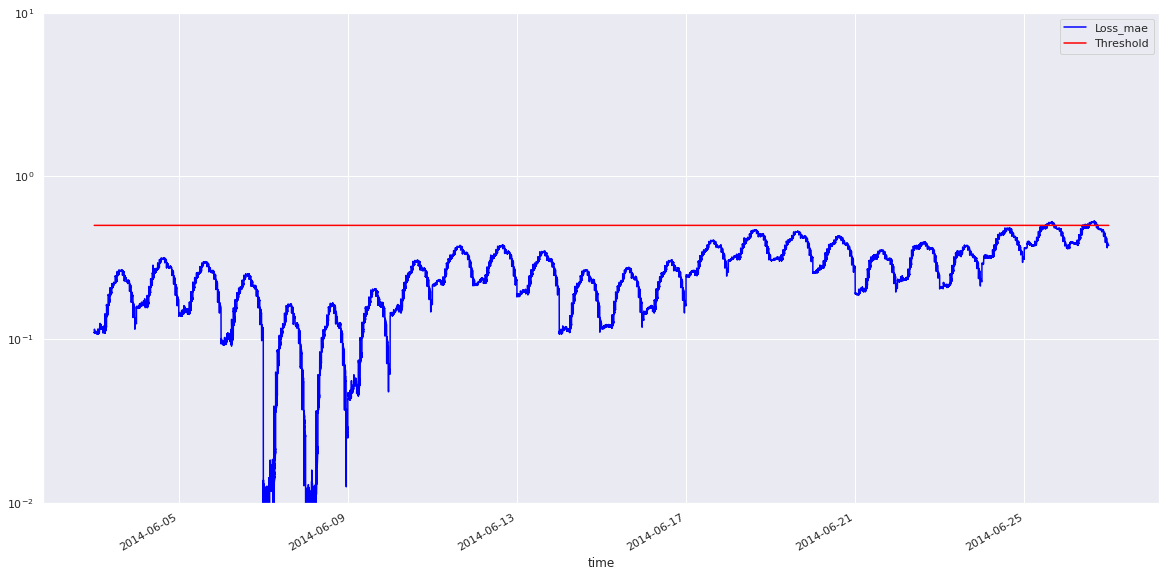

In [66]:
#Plotting the reconstruction error across the entire dataset, any value that crosses the threshold is flagged as possible anomalous event
scored.plot(logy=True,  figsize = (20,10), ylim = [1e-2,1e1], color = ['blue','red'])


In [ ]:
scored.to_csv('householdvae.csv')

In [32]:
%load_ext tensorboard

The tensorboard module is not an IPython extension.
